# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#проверим-баланс-классов" data-toc-modified-id="проверим-баланс-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>проверим баланс классов</a></span></li><li><span><a href="#Лемматизация-текста-и-последующее-удаление-стоп-слов" data-toc-modified-id="Лемматизация-текста-и-последующее-удаление-стоп-слов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация текста и последующее удаление стоп-слов</a></span></li><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разделение данных</a></span></li></ul></li><li><span><a href="#Векторизация-(TF-IDF)" data-toc-modified-id="Векторизация-(TF-IDF)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Векторизация (TF-IDF)</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-пайплайна" data-toc-modified-id="Подготовка-пайплайна-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка пайплайна</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
# импорты библиотек 
import numpy as np
import pandas as pd

import re
import nltk
import torch

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import word_tokenize
import nltk
from tqdm import tqdm 

from scipy.stats import randint
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from tqdm import notebook

from transformers import BertForSequenceClassification
from transformers import BertTokenizer 
from transformers import pipeline
from lightgbm import LGBMClassifier
from pymystem3 import Mystem
from scipy.stats import loguniform, randint

# Константы
RANDOM_STATE = 42
N_ITER = 30
CV_FOLDS = 5

## Подготовка

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(df.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков в данных не обнаружено, типы данных соответствующие

### проверим баланс классов

0    0.898388
1    0.101612
Name: toxic, dtype: float64


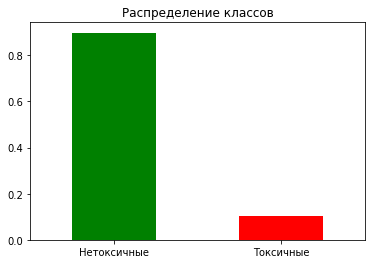

In [5]:
import matplotlib.pyplot as plt

class_dist = df['toxic'].value_counts(normalize=True)
print(class_dist)

class_dist.plot(kind='bar', color=['green', 'red'])
plt.title('Распределение классов')
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'], rotation=0)
plt.show()

### Лемматизация текста и последующее удаление стоп-слов

In [6]:
# Скачивание необходимых данных
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


tqdm.pandas()

def get_wordnet_pos(treebank_tag):
    """Конвертация POS-тегов для WordNetLemmatizer"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def lemmatize_english_text(text):
    """Лемматизация английского текста с учетом POS-тегов"""
    try:
        # Очистка текста
        text = re.sub(r'[^a-zA-Z ]', ' ', str(text))
        words = word_tokenize(text.lower())
        
        # Получение POSтегов
        pos_tags = pos_tag(words)
        
        # Лемматизация с фильтрацией
        lemmas = []
        for word, tag in pos_tags:
            if word not in stop_words and len(word) > 2:
                pos = get_wordnet_pos(tag)
                lemma = lemmatizer.lemmatize(word, pos=pos)
                lemmas.append(lemma)
                
        return ' '.join(lemmas)
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return ''


df['lemm_text'] = df['text'].progress_apply(lemmatize_english_text)

# Проверка 
print("Проверка:")
sample = df.sample(3)
for orig, lemm in zip(sample['text'], sample['lemm_text']):
    print(f"оригинал: {orig[:70]}...")
    print(f"лемма: {lemm[:70]}...\n")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 159292/159292 [08:39<00:00, 306.72it/s]


Проверка:
оригинал: Why are you implying that I am a Muslim? If someone doesn't support cr...
лемма: imply muslim someone support criminal fanatic like shiv sena remain hi...

оригинал: March 2011 (UTC)

Actually I'll address the concerns (as the site admi...
лемма: march utc actually address concern site admin site truly much ad link ...

оригинал: I am primarily a reader rather than a writer of the encyclopaedia. I h...
лемма: primarily reader rather writer encyclopaedia neither time interest nee...



### Разделение данных

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['toxic'], test_size=0.2, random_state=RANDOM_STATE, stratify=df['toxic']
)

## Векторизация (TF-IDF)

In [8]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Обучение

### Подготовка пайплайна

In [9]:
pipe_final = Pipeline([
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])


param_grid = [
    # LogisticRegression
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'model__C': np.linspace(5, 10, 15),
        'model__penalty': ['l1','l2'],
        'model__solver':['liblinear'],
    },
    
    # RandomForest
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': randint(50, 300),
        'model__max_depth': [None, 10, 30],
        'model__min_samples_split': randint(2, 10)
    },
    # LGBM
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__max_depth': [3, 5, 7],  
        'model__learning_rate': [0.1, 0.05],  
        'model__n_estimators': [50, 100]
    }]
    

# Инициализация RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    n_iter=N_ITER,
    cv=CV_FOLDS,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)


randomized_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  20.9s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  20.3s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  20.0s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  19.3s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  20.3s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estimators=50; total time=  20.1s
[CV] END model=LGBMClassifier(random_state=42), model__learning_rate=0.05, model__max_depth=3, model__n_estima

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression(C=5.0,
                                                                      max_iter=1000,
                                                                      penalty='l1',
                                                                      random_state=42,
                                                                      solver='liblinear')],
                                         'model__C': array([ 5.        ,  5.35714286,  5.71428571,  6.07142857,  6.42857143,
        6.78571429,  7.14285714,  7.5       ,  7.85714286,  8.21428571...
                                         'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb2d94d4c10>,
                   

In [10]:
# оценка качества
print('Лучшая модель и параметры:\n', randomized_search.best_estimator_)
print('F1:', randomized_search.best_score_)

y_test_pred = randomized_search.best_estimator_.predict(X_test_tfidf)


print(f'\nF1 (test): {f1_score(y_test, y_test_pred):.4f}')


Лучшая модель и параметры:
 Pipeline(steps=[('model',
                 LogisticRegression(C=5.0, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])
F1: 0.7773727494323849

F1 (test): 0.7796


## Выводы

В данном проекте мы закрепили свои знания по применению машинного обучения для анализа текста, в данном проекте использовали классический метод векторизации текстов TF-IDF, а далее использвоали самые распространенные модели МО: Логистическая регрессия, Случайный лес и LGBM.

Предобработка текста вклбчала в себя этап "Лемматизации", на котором мы привели все твиты к нижнему регистру, очистили от лишних символов, а также удалили стоп-слова.

Определена лучшая модель - это LogisticRegression со следующими параметрами: 
- **Pipeline(steps=[('model',
                 LogisticRegression(C=5.0, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])**
                                    
Значение метрики F1 для тренировочных данных составило **0.778 < 0.75**, а на тестовых - **0.78 < 0.75**. 